# Solving a Partial Differential Equation (PDE) using a Physics-Informed Neural Network (PINN) using adaptive weights at collocation points
Let's solve the following PDE as an example:

$$ -\nabla^2 u(x,y)  = f(x,y), \quad x,y \in \Omega = (0,1)^2$$
$$ u(x,y) = \frac{1-x^2-y^2}{4} + \sin(\pi x)\sin(\pi y), \qquad \text{ on } \partial \Omega $$

This solution and the corresponding source term is given as
$$u(x,y) = \frac{1-x^2-y^2}{4} + \sin(\pi x) \sin(\pi y)$$
$$f(x,y) = 1 + 2\pi^2 \sin(\pi x) \sin(\pi y)$$


# **Step 1: Define the Neural Network**

Create a neural network that takes temporal coordinates as inputs and outputs the solution to the PDE at those points. Ensure that the network has enough capacity (layers and neurons) to capture the complexity of the solution.

In [3]:
import torch
import torch.nn as nn
import numpy as np

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

torch.set_default_dtype(torch.float64)

class PDE_Net_adaptive(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers, hidden_features, use_adaptive_activation=False):
        super(PDE_Net_adaptive, self).__init__()

        self.use_adaptive_activation = use_adaptive_activation

        # Initialize input, hidden, and output layers
        self.linearIn = nn.Linear(in_features, hidden_features)
        self.linear = nn.ModuleList([nn.Linear(hidden_features, hidden_features) for _ in range(hidden_layers)])
        self.linearOut = nn.Linear(hidden_features, out_features)

        # Adaptive activation parameters
        if use_adaptive_activation:
            self.n = 10
            self.ada_act_funs = nn.ParameterList([nn.Parameter(torch.tensor(1. / self.n), requires_grad=True) for _ in range(hidden_layers)])

        # Fixed activation function
        self.act = nn.Tanh()

        # Initialize weights and biases
        self.initialize_weights()

    def initialize_weights(self):
        # He initialization for weights and zeros for biases
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='tanh')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, coord):
        # Extract x and y coordinates and ensure they are column vectors
        x_coord = coord[:,0].unsqueeze(1)
        y_coord = coord[:,1].unsqueeze(1)

        # Forward pass through the network
        x_out = self.act(self.linearIn(coord))
        for i, layer in enumerate(self.linear):
            if self.use_adaptive_activation:
                x_out = self.act(self.n * self.ada_act_funs[i] * layer(x_out))
            else:
                x_out = self.act(layer(x_out))
        x_out = self.linearOut(x_out)

        # Length factor function to impose conditions such as zero boundary conditions on the solution
        lenght_factor_fun = x_coord * (1.-x_coord) * y_coord * (1.-y_coord)
        bc = 0.25*(1. - (x_coord * x_coord) - (y_coord * y_coord))
        # We need to add an additional term here if the g(bc) is not zero
        # x_out = g(bc) + lenght_factor_fun * x_out
        x_out = bc + lenght_factor_fun * x_out

        return x_out

# **Step 2: Define the Loss Function for the PDE**

This function calculates the residual of a partial differential equation (PDE) using the predicted solution `u_pred` and the spatial coordinates `x`. It operates as follows:
The loss function should include the PDE's residual (the difference between the left-hand side and right-hand side of the PDE).

In [4]:
def compute_pde_residual(u_pred, x, rhs_f):
    grad_u_pred = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred),
            retain_graph=True, create_graph=True, only_inputs=True)[0]

    grad2_u_pred_xx = torch.autograd.grad(grad_u_pred[:, 0].unsqueeze(1), x, grad_outputs=torch.ones_like(u_pred),
            retain_graph=True, create_graph=True, only_inputs=True)[0][:, 0]
    grad2_u_pred_yy = torch.autograd.grad(grad_u_pred[:, 1].unsqueeze(1), x, grad_outputs=torch.ones_like(u_pred),
            retain_graph=True, create_graph=True, only_inputs=True)[0][:, 1]

    # PDE residual
    residual = (-grad2_u_pred_xx - grad2_u_pred_yy - rhs_f)

    return residual

def eval_pde_loss(u_pred, x, rhs_f):
    residual = compute_pde_residual(u_pred, x, rhs_f)
    loss_pde = (residual.pow(2)).mean()

    return loss_pde

# **Step 3: Define the Loss Function for enforcing Dirichlet boundary conditions**

This function calculates the loss associated with the boundary conditions.

In [5]:
def eval_loss_bc(u_pred_1, u_pred_2, u_pred_3, u_pred_4, u_bc_1, u_bc_2,u_bc_3, u_bc_4):
    # Enforce the initial condition
    loss_bc = (u_pred_1 - u_bc_1).pow(2).mean() + (u_pred_2 - u_bc_2).pow(2).mean() + (u_pred_3 - u_bc_3).pow(2).mean() + + (u_pred_4 - u_bc_4).pow(2).mean()
    return loss_bc

In [6]:
def rhs_f(x):
    pi = torch.acos(torch.zeros(1)).item() * 2  # Pi using arccos
    return 1 # + pi * pi * torch.sin(pi * x[:, 0]) * torch.sin(pi * x[:, 1])/2.

In [7]:
def analytical_u(x):
  pi = torch.acos(torch.zeros(1)).item() * 2  # Pi using arccos
  return (1. - x[:, 0]**2 - x[:, 1]**2 )/4. # + (torch.sin(pi * x[:, 0]) * torch.sin(pi * x[:, 1]))/4.

Computing relative $L_2$ error
$$
\mathcal{E}_{\text{rel}} = \frac{\|u^\ast - u_{\text{NN}} \|_{L^2(\Omega)} }{\|u^\ast\|_{L^2(\Omega)} }
$$

In [8]:
def compute_relative_l2_error(u_pred, u_exact):
    diff = u_pred - u_exact
    error = torch.sqrt(torch.dot(diff,diff))
    norm_true = torch.sqrt(torch.dot(u_exact,u_exact))
    return (error / norm_true)

# **Step 4: Prepare Training Data**

Generate collocation points for calculating the residuals, and points for enforcing initial conditions. These can be randomly sampled or placed on a grid.


In [ ]:
# ! pip install scikit-optimize

In [9]:
import skopt
import numpy as np

# Number of collocation points in the interior and boundary of the domain
num_samples = 500
num_samples_bc = 50

# Define the domain and collocation points
space   = [(0., 1.), (0., 1.)]
sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1)
train_collocation = np.array(sampler.generate(space, num_samples))

# Define the boundary and collocation points
train_collocation_bc = np.linspace(0, 1, num_samples_bc)
train_collocation_bc = train_collocation_bc.reshape(num_samples_bc,1)

# arrays of ones and zeros
z = np.zeros((num_samples_bc, 1))
o = np.ones((num_samples_bc, 1))

# Padding the collation points with ones and zeros to place them on the respective boundaries
train_collocation_bc_1 = np.concatenate((train_collocation_bc, z), axis=1)
train_collocation_bc_2 = np.concatenate((o, train_collocation_bc), axis=1)
train_collocation_bc_3 = np.concatenate((train_collocation_bc, o), axis=1)
train_collocation_bc_4 = np.concatenate((z, train_collocation_bc), axis=1)

# convert all numpy arrays to Torch
train_collocation = torch.tensor(train_collocation)
train_collocation_bc_1 = torch.tensor(train_collocation_bc_1)
train_collocation_bc_2 = torch.tensor(train_collocation_bc_2)
train_collocation_bc_3 = torch.tensor(train_collocation_bc_3)
train_collocation_bc_4 = torch.tensor(train_collocation_bc_4)

train_collocation_bc = {
    "bc_1": train_collocation_bc_1,
    "bc_2": train_collocation_bc_2,
    "bc_3": train_collocation_bc_3,
    "bc_4": train_collocation_bc_4
}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.7 MB/s eta 0:00:00


## Visualize the training data (collocation points)

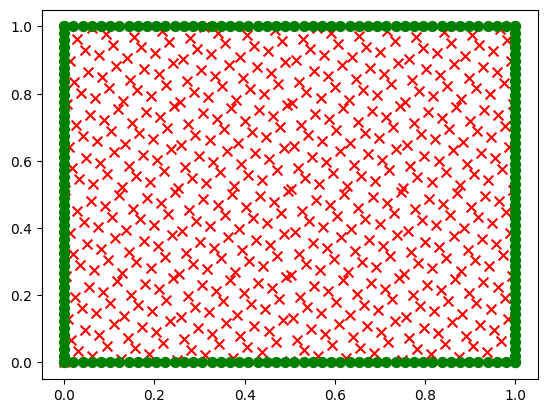

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(train_collocation[:,0],train_collocation[:,1], color='red', s=50, marker='x', label='Collocation Points')
plt.scatter(train_collocation_bc_1[:,0],train_collocation_bc_1[:,1], color='green', s=50, label='Collocation Points')
plt.scatter(train_collocation_bc_2[:,0],train_collocation_bc_2[:,1], color='green', s=50, label='Collocation Points')
plt.scatter(train_collocation_bc_3[:,0],train_collocation_bc_3[:,1], color='green', s=50, label='Collocation Points')
plt.scatter(train_collocation_bc_4[:,0],train_collocation_bc_4[:,1], color='green', s=50, label='Collocation Points')


# **Step 5: Prepare Testing Data**
We use the uniform collocation points for testing data.

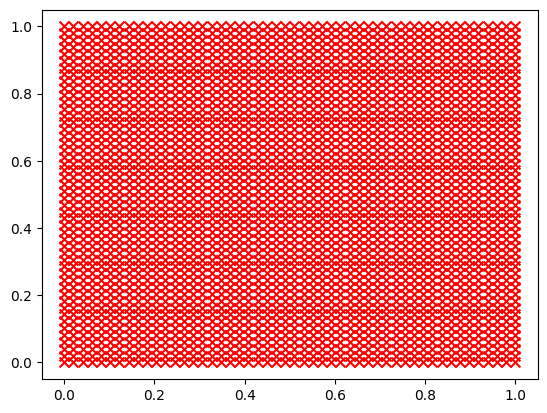

In [ ]:
xmin = 0.
ymin = 0.
xmax = 1.
ymax = 1.

X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
test_collocation = np.vstack([X.ravel(), Y.ravel()]).T
test_collocation = torch.tensor(test_collocation)

plt.scatter(test_collocation[:,0],test_collocation[:,1], color='red', s=50, marker='x', label='Collocation Points')


## Construct boundary conditions


In [ ]:
u_bc_1 = analytical_u(train_collocation_bc_1)
u_bc_2 = analytical_u(train_collocation_bc_2)
u_bc_3 = analytical_u(train_collocation_bc_3)
u_bc_4 = analytical_u(train_collocation_bc_4)
u_bc_1 = u_bc_1.unsqueeze(1)
u_bc_2 = u_bc_2.unsqueeze(1)
u_bc_3 = u_bc_3.unsqueeze(1)
u_bc_4 = u_bc_4.unsqueeze(1)

# **Step 6: *Define* the network and the optimizer, and train the network**


In [ ]:
model = PDE_Net_adaptive(in_features=2, out_features=1, hidden_layers=2, hidden_features=50, use_adaptive_activation=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=1e-5)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=1, max_iter=20, history_size=10, tolerance_grad=1e-5, tolerance_change=1e-9,line_search_fn='strong_wolfe')

In [ ]:
num_epochs = 500

u_exact_train = analytical_u(train_collocation)
u_exact_test = analytical_u(test_collocation)

# Track the best loss
best_loss = np.inf
best_model_path = 'best_model_reg.pth'


# Adding extra weight vector in the training algorithm

In [ ]:
def train_model(model, optimizer, num_epochs, train_collocation, train_collocation_bc, test_collocation, u_exact_train, u_exact_test, best_model_path):

    best_loss = float('inf')

    # Define the weights for the loss terms and their optimizer
    # w_bc = torch.tensor(1.0, requires_grad=True)
    # w_pde = torch.tensor(1.0, requires_grad=True)

    # Define the weights for each collocation point
    weights_pde = torch.one(train_collocation.size(0), requires_grad=True)

    # Dictionary to track losses
    loss_history = {'total': [], 'pde': [], 'bc': []}
    l2_history = {'train': [], 'test': []}
    w_history = {'pde': [], 'bc': []}

    for epoch in range(num_epochs):
        train_collocation.requires_grad = True
        test_collocation.requires_grad = False

        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()

            # Predict in the interior part and calculate PDE loss
            u_pred_train = model(train_collocation)
            f_train = rhs_f(train_collocation)

            # PDE residual
            pde_residual = compute_pde_residual(u_pred_train, train_collocation, f_train)

            loss_pde = eval_pde_loss(u_pred_train, train_collocation, f_train)
            loss_pde = (weights_pde * pde_residual.pow(2)).mean()

            # boundary loss
            u_nn_bc_1 = model(train_collocation_bc['bc_1'])
            u_nn_bc_2 = model(train_collocation_bc['bc_2'])
            u_nn_bc_3 = model(train_collocation_bc['bc_3'])
            u_nn_bc_4 = model(train_collocation_bc['bc_4'])
            loss_bc = eval_loss_bc(u_nn_bc_1, u_nn_bc_2, u_nn_bc_3, u_nn_bc_4, u_bc_1, u_bc_2,u_bc_3, u_bc_4)

            # Add all loss components
            total_loss = loss_pde + loss_bc

            # w_history['bc'].append(w_bc.item())
            # w_history['pde'].append(w_pde.item())

            # Log losses for analysis
            loss_history['pde'].append(loss_pde.item())
            loss_history['bc'].append(loss_bc.item())
            loss_history['total'].append(total_loss.item())

            if total_loss.requires_grad:
                total_loss.backward()

            return total_loss

        # Update the weights using the optimizer
        optimizer.step(closure)

        # After optimizer step, extract the losses again for logging and checks
        total_loss = closure().item()  # This will execute zero_grad, forward, backward again

        # Access data without computing gradients
        with torch.no_grad():
            u_pred_train = model(train_collocation).squeeze()
            u_pred_test = model(test_collocation).squeeze()

            # Compute errors
            l2_train = compute_relative_l2_error(u_pred_train.detach(), u_exact_train)
            l2_test = compute_relative_l2_error(u_pred_test.detach(), u_exact_test)

            # Store error history
            l2_history['train'].append(l2_train.item())
            l2_history['test'].append(l2_test.item())

            # Update w_pde and w_bc using gradient ascent
            weights_pde += weights_pde.grad * 0.01  # Manually apply ascent step
            weights_pde.grad.zero_()

        # Optional print statement every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1:4d}/{num_epochs:4d}], Total Loss: {total_loss:.4e}, Train error: {l2_train:.4e}, Test error: {l2_test:.4e}')

        # Save the best model
        if total_loss < best_loss:
            best_loss = total_loss
            torch.save(model.state_dict(), best_model_path)

    return loss_history, l2_history, weights_pde

In [ ]:
losses_history, l2_history, weights_pde = train_model(model, optimizer, num_epochs, train_collocation, train_collocation_bc, test_collocation, u_exact_train, u_exact_test, best_model_path)

Epoch [ 100/ 500], Total Loss: 2.6445e-05, Train error: 1.3815e-03, Test error: 1.3540e-03
Epoch [ 200/ 500], Total Loss: 7.2267e-06, Train error: 2.4054e-04, Test error: 2.3575e-04
Epoch [ 300/ 500], Total Loss: 3.9742e-06, Train error: 1.3909e-04, Test error: 1.3631e-04
Epoch [ 400/ 500], Total Loss: 2.6236e-06, Train error: 8.7871e-05, Test error: 8.6123e-05
Epoch [ 500/ 500], Total Loss: 1.9552e-06, Train error: 6.3727e-05, Test error: 6.2467e-05


# **Step 7: Postprocessing: analysing erros and loss over training**

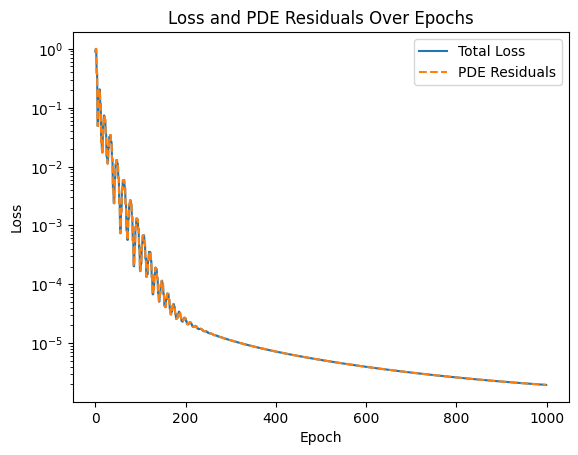

In [ ]:
plt.semilogy(losses_history['total'], label='Total Loss')
plt.semilogy(losses_history['pde'], label='PDE Residuals', linestyle='--')
#plt.semilogy(losses_history['bc'], label='BC Residuals', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss and PDE Residuals Over Epochs')
plt.legend()

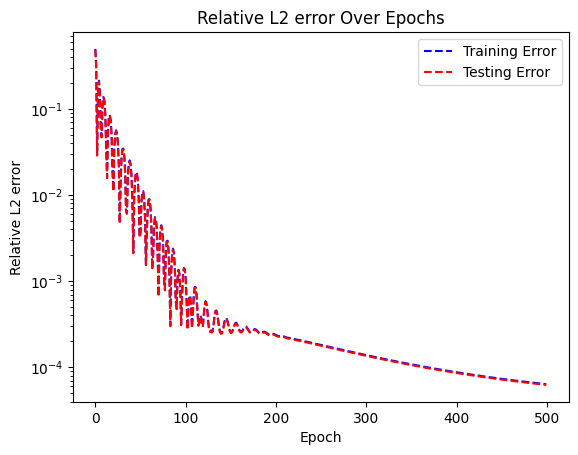

In [ ]:
plt.semilogy(l2_history['train'], label='Training Error', linestyle='--', color='blue')
plt.semilogy(l2_history['test'], label='Testing Error', linestyle='--', color='red')

plt.xlabel('Epoch')
plt.ylabel('Relative L2 error')
plt.title('Relative L2 error Over Epochs')
plt.legend()


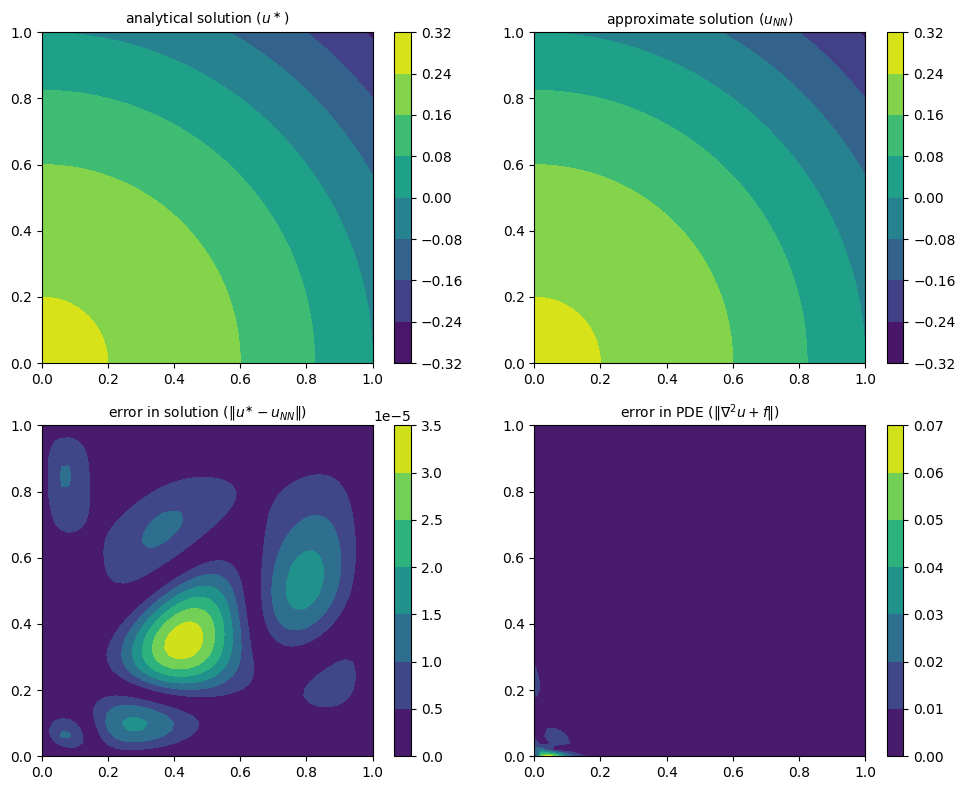

In [ ]:
test_collocation.requires_grad = True

model.load_state_dict(torch.load(best_model_path))

u_nn_domain = model(test_collocation)
f_test = rhs_f(test_collocation)


pde_error = compute_pde_residual(u_nn_domain, test_collocation, f_test)
pde_error = pde_error.data.numpy()
pde_error = pde_error.reshape(X.shape)

u_analytical = analytical_u(test_collocation)
u_analytical = u_analytical.reshape(X.shape)
u_analytical = u_analytical.data.numpy()

u_nn_domain = u_nn_domain.data.numpy()
u_nn_domain = u_nn_domain.reshape(X.shape)


fig, axs = plt.subplots(2, 2, figsize=(10, 8))
ax = axs[0, 0]
pcm = ax.contourf(X, Y, u_analytical, cmap='viridis')
ax.set_title('analytical solution 'r'($u^\ast$)', fontsize=10)
ax.set_aspect('equal', 'box')
fig.colorbar(pcm, ax=ax)


ax = axs[0, 1]
pcm = ax.contourf(X, Y, u_nn_domain, cmap='viridis')
ax.set_aspect('equal', 'box')
ax.set_title('approximate solution ($u_{NN}$)', fontsize=10)
fig.colorbar(pcm, ax=ax)


ax = axs[1, 0]
pcm = ax.contourf(X, Y, abs(u_nn_domain - u_analytical))
ax.set_aspect('equal', 'box')
ax.set_title('error in solution 'r'($\|u^{\ast} - u_{NN}\|$)', fontsize=10)
fig.colorbar(pcm, ax=ax)

ax = axs[1, 1]
pcm = ax.contourf(X, Y, abs(pde_error))
ax.set_aspect('equal', 'box')
ax.set_title('error in PDE 'r'($\| \nabla^2 u + f \|$)', fontsize=10)
fig.colorbar(pcm, ax=ax)

fig.tight_layout()

plt.show()

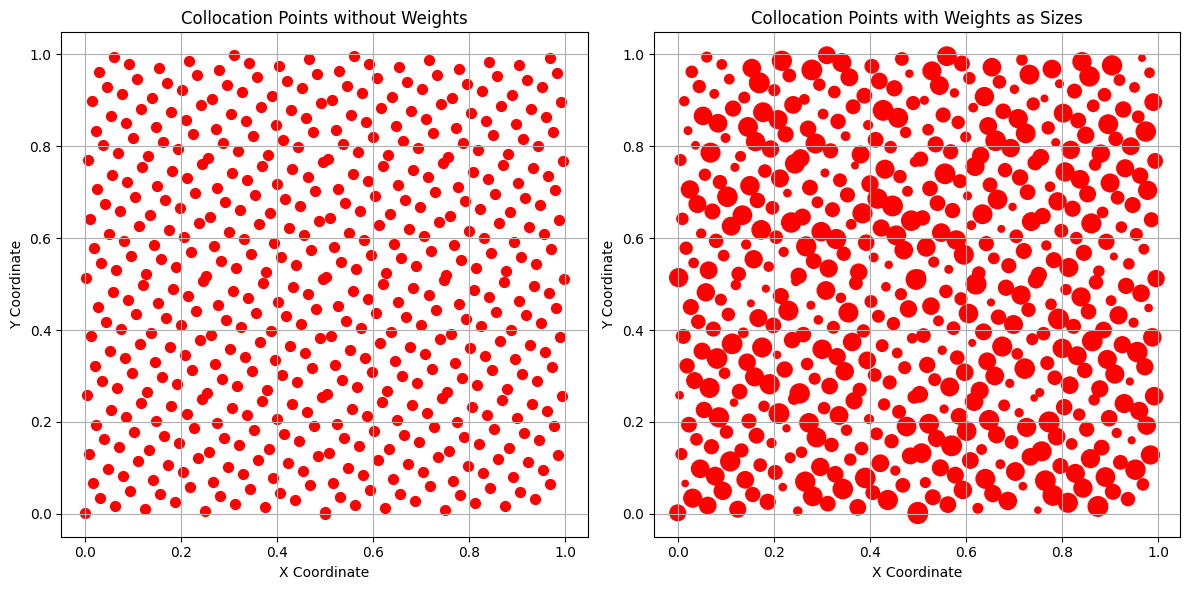

In [ ]:
#test_collocation = test_collocation.detach().numpy()
weights_scaled = (weights_pde - weights_pde.min()) / (weights_pde.max() - weights_pde.min()) * 180 + 20
weights_scaled = weights_scaled.detach().numpy()

train_collocation_np = train_collocation.detach().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot without weights
axes[0].scatter(train_collocation_np[:, 0], train_collocation_np[:, 1], color='red', s=50, marker='o')
axes[0].set_title("Collocation Points without Weights")
axes[0].set_xlabel("X Coordinate")
axes[0].set_ylabel("Y Coordinate")
axes[0].grid(True)

# Plot with weights
axes[1].scatter(train_collocation_np[:, 0], train_collocation_np[:, 1], s=weights_scaled, color='red', marker='o')
axes[1].set_title("Collocation Points with Weights as Sizes")
axes[1].set_xlabel("X Coordinate")
axes[1].set_ylabel("Y Coordinate")
axes[1].grid(True)

# Show the plot
plt.tight_layout()
plt.show()

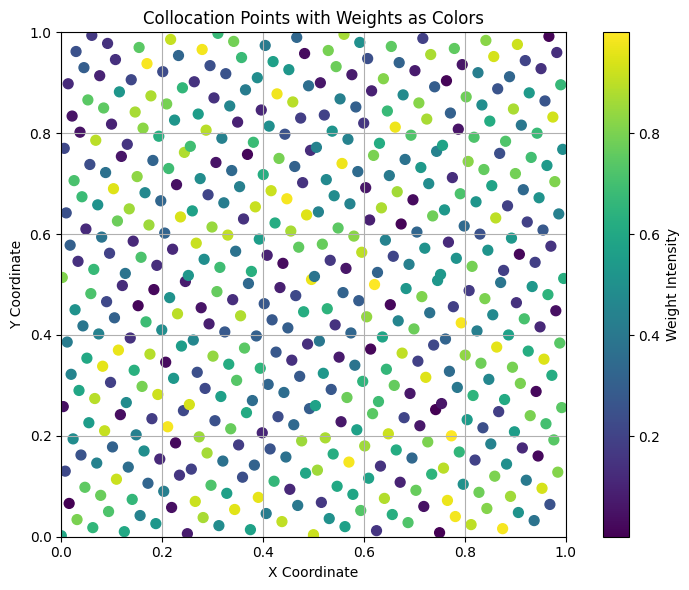

In [ ]:
# Normalize weights for color mapping
weights_color = (weights_pde - weights_pde.min()) / (weights_pde.max() - weights_pde.min())
weights_color = weights_color.detach().numpy()  # Detach and convert to numpy for plotting
weights_color = weights_pde.detach().numpy()

# Convert train_collocation to numpy for plotting
train_collocation_np = train_collocation.detach().numpy()

# Create a figure and a single subplot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(train_collocation_np[:, 0], train_collocation_np[:, 1], c=weights_color, cmap='viridis', s=50, marker='o')
plt.title("Collocation Points with Weights as Colors")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')  # Ensuring equal aspect ratio

# Adding a colorbar to show the weight scale
cbar = plt.colorbar(scatter, orientation='vertical')
cbar.set_label('Weight Intensity')

# Show the plot
plt.tight_layout()
plt.show()
